In [12]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import shap
import warnings
warnings.filterwarnings('ignore')

In [13]:
# CONFIGURATION
base_path = "C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/Auto Data/Merged/"
sc_file = "sc_cleaned_combined_2013_2022.csv"
fars_file = "FARS_combined_cleaned_2013-2023.csv"

In [14]:
# Load Data
sc_df = pd.read_csv(os.path.join(base_path, sc_file), dtype=str)
fars_df = pd.read_csv(os.path.join(base_path, fars_file), dtype=str)

for df in [sc_df, fars_df]:
    df["crash_date"] = pd.to_datetime(df["crash_date"], errors="coerce")
    df["severity_level"] = pd.to_numeric(df["severity_level"], errors="coerce")
    df["driver_age"] = pd.to_numeric(df["driver_age"], errors="coerce")
    df["opioid_flag"] = pd.to_numeric(df["opioid_flag"], errors="coerce")
    df["alcohol_flag"] = pd.to_numeric(df["alcohol_flag"], errors="coerce")
    df["any_drug_flag"] = pd.to_numeric(df["any_drug_flag"], errors="coerce")

In [15]:
# Function to perform EDA and Modeling

def full_pipeline(df, dataset_name="SC"):
    print(f"\n==== Analyzing {dataset_name} Dataset ====")

    # 1. EDA
    plt.figure(figsize=(10,6))
    df.groupby(df['crash_date'].dt.year)['opioid_flag'].mean().plot(marker='o')
    plt.title(f"Opioid Involvement Rate by Year ({dataset_name})")
    plt.ylabel("Proportion of Opioid-Related Crashes")
    plt.xlabel("Year")
    plt.grid()
    plt.show()

    plt.figure(figsize=(10,8))
    corr = df[['fatalities', 'injuries', 'driver_age', 'opioid_flag', 'alcohol_flag', 'any_drug_flag', 'severity_level']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f"Feature Correlation Heatmap ({dataset_name})")
    plt.show()

    features = ['driver_age', 'opioid_flag', 'alcohol_flag', 'any_drug_flag', 'fatalities', 'injuries']
    X_scaled = StandardScaler().fit_transform(df[features].fillna(0))
    pca = PCA()
    pca.fit(X_scaled)
    plt.figure(figsize=(8,5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f'PCA Scree Plot ({dataset_name})')
    plt.grid()
    plt.show()

    # Time Split
    df = df.sort_values('crash_date')
    train = df[(df['crash_date'].dt.year >= 2013) & (df['crash_date'].dt.year <= 2020)]
    valid = df[(df['crash_date'].dt.year == 2021)]
    test = df[(df['crash_date'].dt.year == 2022)]

    # --- INSERT THIS SINGLE CHECK ---
    print(f"--- Checking {dataset_name} inside function ---")
    print(f"Shape of 'test' DataFrame (year 2022 filter result): {test.shape}")
    if test.empty:
        print(f"  >>> ERROR: The 'test' DataFrame is EMPTY. No data found for 2022.")
        print(f"  >>> Cannot proceed with modeling for {dataset_name}.")
        # Optional: You might want to stop the function here if test is empty
        # return
    else:
        print(f"  >>> OK: The 'test' DataFrame has {test.shape[0]} rows for 2022.")
    print(f"--- End check ---")
    # --- END OF INSERTED CHECK ---

    X_train = train[['driver_age', 'alcohol_flag', 'any_drug_flag']]
    y_train_opioid = train['opioid_flag']
    y_train_severity = train['severity_level']

    X_test = test[['driver_age', 'alcohol_flag', 'any_drug_flag']]
    y_test_opioid = test['opioid_flag']
    y_test_severity = test['severity_level']

    # Baseline Logistic Regression
    print("\n=== Logistic Regression for Opioid Prediction ===")
    base_model = LogisticRegression(max_iter=1000)
    base_model.fit(X_train, y_train_opioid)
    y_pred = base_model.predict(X_test)
    print(classification_report(y_test_opioid, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test_opioid, base_model.predict_proba(X_test)[:,1]))

    # SMOTE for Severity Prediction
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, y_train_severity)

    # XGBoost with GridSearch
    print("\n=== XGBoost with SMOTE for Severity Prediction ===")
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    param_grid = {
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.05],
        'n_estimators': [100, 200]
    }
    grid = GridSearchCV(xgb, param_grid, scoring='f1_weighted', cv=3)
    grid.fit(X_res, y_res)

    best_xgb = grid.best_estimator_
    y_pred_severity = best_xgb.predict(X_test)
    print(classification_report(y_test_severity, y_pred_severity))

    # SHAP Values
    explainer = shap.TreeExplainer(xgb)
    shap_values = explainer.shap_values(X_test)

    print("\n=== SHAP Summary for Severity Prediction ===")
    shap.summary_plot(shap_values, X_test, feature_names=X_test.columns.tolist())


==== Analyzing SC Dataset ====


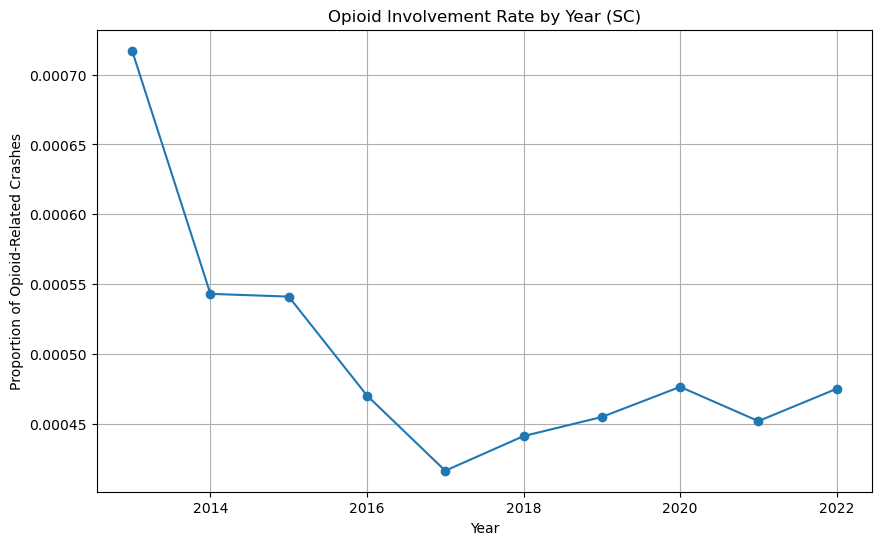

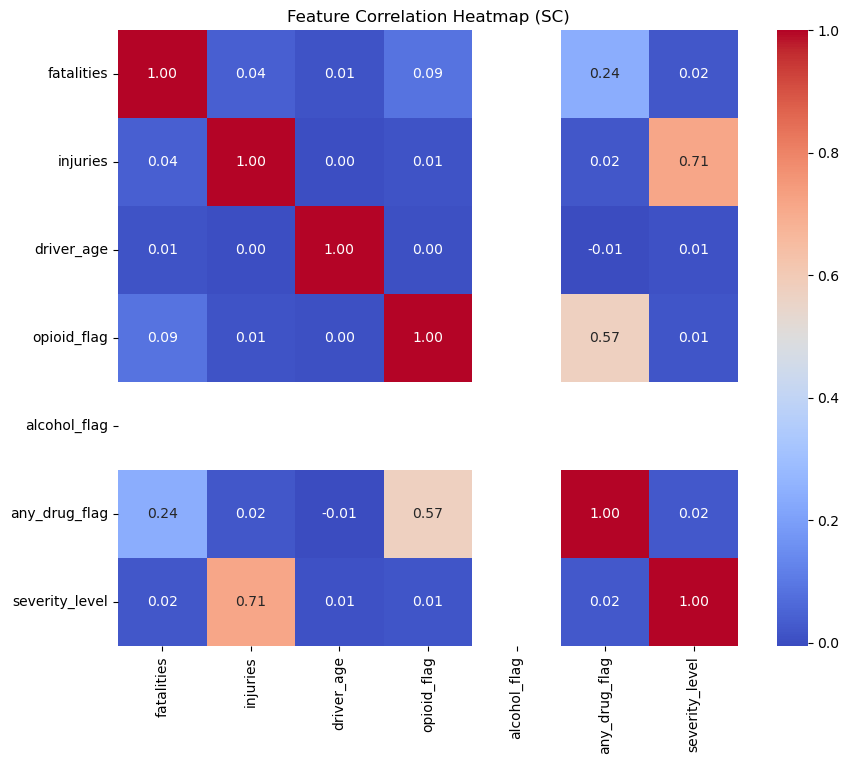

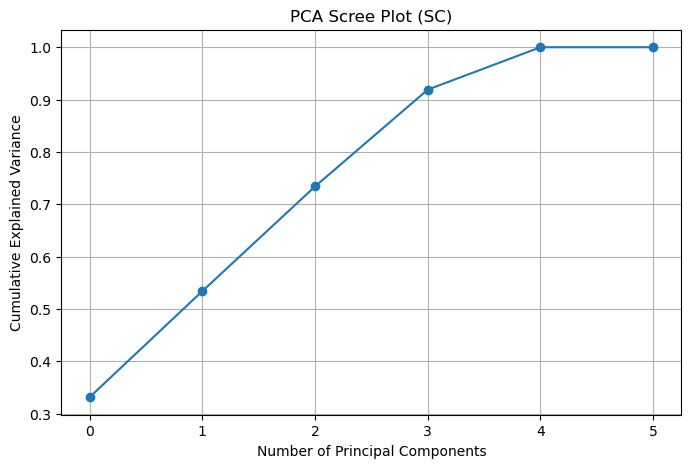

--- Checking SC inside function ---
Shape of 'test' DataFrame (year 2022 filter result): (267346, 14)
  >>> OK: The 'test' DataFrame has 267346 rows for 2022.
--- End check ---

=== Logistic Regression for Opioid Prediction ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    267219
           1       0.38      0.29      0.33       127

    accuracy                           1.00    267346
   macro avg       0.69      0.65      0.67    267346
weighted avg       1.00      1.00      1.00    267346

ROC-AUC: 0.9995206827464912

=== XGBoost with SMOTE for Severity Prediction ===
              precision    recall  f1-score   support

           0       0.86      0.17      0.29    220265
           1       0.01      0.40      0.02      1223
           2       0.01      0.46      0.02      2623
           3       0.05      0.07      0.06     12115
           4       0.12      0.12      0.12     31120

    accuracy                           

IndexError: index 4 is out of bounds for axis 1 with size 3

<Figure size 640x480 with 0 Axes>

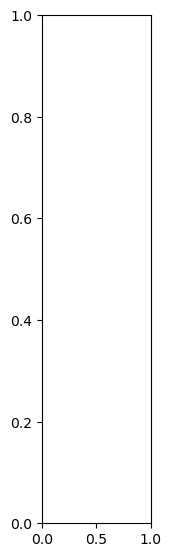

In [16]:
# Run pipeline on SC
full_pipeline(sc_df, dataset_name="SC")

# Run pipeline on FARS
full_pipeline(fars_df, dataset_name="FARS")